In [98]:
# from gurobipy import Model, GRB, quicksum

# # Initialize the model
# model = Model("VRPSPD")

# # Define sets
# nodes = [0, 1, 2, 3, 4]  # 0 is the depot
# customer_nodes = [1, 2, 3, 4]  # Excluding depot
# vehicles = [0, 1]  # Two vehicles
# K = len(vehicles)  # Total number of vehicles

# # Example data
# distance = {(i, j): 10 for i in nodes for j in nodes if i != j}  # Dummy distances
# capacity = 100  # Vehicle capacity Q
# pickup = {1: 10, 2: 15, 3: 20, 4: 25}
# delivery = {1: 5, 2: 10, 3: 15, 4: 20}
# M1 = 1000  # Big-M constant for delivery
# M2 = 1000  # Big-M constant for load
# vehicle_cost = 15  # Fixed cost per vehicle used

# # Decision Variables
# x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
# y = model.addVars(vehicles, vtype=GRB.BINARY, name="y")  # New variable for vehicle usage
# D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")  # Delivery load
# L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")  # Total load

# # Prevent self-loops
# for i in nodes:
#     model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

# # **Constraint 1: Each customer node is left by exactly one vehicle**
# for j in customer_nodes:
#     model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")

# # **Constraint 2: Each customer node is approached by exactly one vehicle**
# for j in customer_nodes:
#     model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

# # **Constraint 3: Link vehicle usage to depot departure**
# for k in vehicles:
#     model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= K * y[k], name=f"vehicle_usage_{k}")

# # **Constraint 4: At end vehicles arrive to the depot**
# model.addConstr(quicksum(x[i, 0] for i in customer_nodes) <= K, name="limit_vehicles_returning_depot")

# # **Constraint 5: Delivery load consistency**
# for i in customer_nodes:
#     for j in customer_nodes:
#         model.addConstr(D[i] >= D[j] + delivery[i] - M1 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")

# # **Constraint 6: Load consistency at customer nodes**
# for j in customer_nodes:
#     model.addConstr(L[j] >= D[j] - delivery[j] + pickup[j], name=f"load_consistency_{j}")

# # **Constraint 7: Load consistency between nodes**
# for i in customer_nodes:
#     for j in customer_nodes:
#         model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - M2 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

# # **Constraint 8: Delivery demand feasibility**
# for i in customer_nodes:
#     model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_lower_{i}")
#     model.addConstr(D[i] <= capacity, name=f"delivery_feasibility_upper_{i}")

# # **Constraint 9: Pickup demand feasibility**
# for i in customer_nodes:
#     model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_lower_{i}")
#     model.addConstr(L[i] <= capacity, name=f"pickup_feasibility_upper_{i}")

# # **Constraint 10: Binary constraint for vehicle routing**
# for i in nodes:
#     for j in nodes:
#         model.addConstr(x[i, j] >= 0, name=f"binary_lb_{i}_{j}")
#         model.addConstr(x[i, j] <= 1, name=f"binary_ub_{i}_{j}")

# # **Constraint 11: Non-negativity of load variables**
# for i in nodes:
#     model.addConstr(D[i] >= 0, name=f"non_negative_D_{i}")
#     model.addConstr(L[i] >= 0, name=f"non_negative_L_{i}")

# # **Objective: Minimize total distance + vehicle cost**
# model.setObjective(
#     quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j) + quicksum(vehicle_cost * y[k] for k in vehicles),
#     GRB.MINIMIZE
# )

# # Solve Model
# model.optimize()


In [ ]:
from gurobipy import Model, GRB, quicksum

class VRPSPD:
    def __init__(self, nodes, customer_nodes, vehicles, distance, capacity, pickup, delivery, M1=1000, M2=1000, vehicle_cost=15):
        self.nodes = nodes
        self.customer_nodes = customer_nodes
        self.vehicles = vehicles
        self.K = len(vehicles)
        self.distance = distance
        self.capacity = capacity
        self.pickup = pickup
        self.delivery = delivery
        self.M1 = M1
        self.M2 = M2
        self.vehicle_cost = vehicle_cost
        self.model = Model("VRPSPD")
        self._build_model()

    def _build_model(self):
        # Decision Variables
        self.x = self.model.addVars(self.nodes, self.nodes, vtype=GRB.BINARY, name="x")
        self.y = self.model.addVars(self.vehicles, vtype=GRB.BINARY, name="y")  # Vehicle usage
        self.D = self.model.addVars(self.nodes, vtype=GRB.CONTINUOUS, name="D")  # Delivery load
        self.L = self.model.addVars(self.nodes, vtype=GRB.CONTINUOUS, name="L")  # Total load

        # Constraints
        for i in self.nodes:
            self.model.addConstr(self.x[i, i] == 0, name=f"no_self_loop_{i}")

        for j in self.customer_nodes:
            self.model.addConstr(quicksum(self.x[i, j] for i in self.nodes if i != j) == 1, name=f"leave_once_{j}")
            self.model.addConstr(quicksum(self.x[j, i] for i in self.nodes if i != j) == 1, name=f"approach_once_{j}")

        for k in self.vehicles:
            self.model.addConstr(quicksum(self.x[0, i] for i in self.customer_nodes) <= self.K * self.y[k], name=f"vehicle_usage_{k}")

        self.model.addConstr(quicksum(self.x[i, 0] for i in self.customer_nodes) <= self.K, name="limit_vehicles_returning_depot")

        for i in self.customer_nodes:
            for j in self.customer_nodes:
                self.model.addConstr(self.D[i] >= self.D[j] + self.delivery[i] - self.M1 * (1 - self.x[i, j]), name=f"delivery_consistency_{i}_{j}")

        for j in self.customer_nodes:
            self.model.addConstr(self.L[j] >= self.D[j] - self.delivery[j] + self.pickup[j], name=f"load_consistency_{j}")

        for i in self.customer_nodes:
            for j in self.customer_nodes:
                self.model.addConstr(self.L[j] >= self.L[i] - self.delivery[j] + self.pickup[j] - self.M2 * (1 - self.x[i, j]), name=f"load_transfer_{i}_{j}")

        for i in self.customer_nodes:
            self.model.addConstr(self.delivery[i] <= self.D[i], name=f"delivery_feasibility_lower_{i}")
            self.model.addConstr(self.D[i] <= self.capacity, name=f"delivery_feasibility_upper_{i}")
            self.model.addConstr(self.pickup[i] <= self.L[i], name=f"pickup_feasibility_lower_{i}")
            self.model.addConstr(self.L[i] <= self.capacity, name=f"pickup_feasibility_upper_{i}")

        for i in self.nodes:
            for j in self.nodes:
                self.model.addConstr(self.x[i, j] >= 0, name=f"binary_lb_{i}_{j}")
                self.model.addConstr(self.x[i, j] <= 1, name=f"binary_ub_{i}_{j}")


        

        for i in self.nodes:
            self.model.addConstr(self.D[i] >= 0, name=f"non_negative_D_{i}")
            self.model.addConstr(self.L[i] >= 0, name=f"non_negative_L_{i}")

        # Objective Function
        self.model.setObjective(
            quicksum(self.distance[i, j] * self.x[i, j] for i in self.nodes for j in self.nodes if i != j) +
            quicksum(self.vehicle_cost * self.y[k] for k in self.vehicles),
            GRB.MINIMIZE
        )

    def solve(self):
        self.model.optimize()
        if self.model.status == GRB.OPTIMAL:
            return self.get_solution()
        return None

    def get_solution(self):
        solution = {
            "x": {(i, j): self.x[i, j].x for i in self.nodes for j in self.nodes if self.x[i, j].x > 0.5},
            "y": {k: self.y[k].x for k in self.vehicles if self.y[k].x > 0.5},
            "D": {i: self.D[i].x for i in self.nodes},
            "L": {i: self.L[i].x for i in self.nodes},
            "objective": self.model.objVal
        }
        return solution


In [115]:
nodes = [0, 1, 2, 3, 4, 5, 6]
customer_nodes = [1, 2, 3, 4, 5, 6]
vehicles = [0, 1, 2, 3]
distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
capacity = 100
pickup = {1: 10, 2: 15, 3: 20, 4: 25, 5: 0, 6: 14}
delivery = {1: 5, 2: 10, 3: 15, 4: 20, 5: 10, 6: 20}

vrp = VRPSPD(nodes, customer_nodes, vehicles, distance, capacity, pickup, delivery)

In [114]:
def reconstruct_routes(solution, nodes, customer_nodes):
    """
    Reconstructs the routes for each vehicle based on the solution.
    """
    # Extract active routes (x[i, j] > 0.5)
    active_routes = [(i, j) for (i, j), value in solution["x"].items() if value > 0.5]
    
    # Initialize routes for each vehicle
    routes = {k: [] for k in range(3)}  # Assuming 3 vehicles
    vehicle_assignment = {k: 0 for k in range(3)}  # Track which vehicle is assigned to which route
    
    # Start from the depot (node 0)
    current_node = 0
    for k in range(3):  # For each vehicle
        route = [current_node]  # Start at the depot
        while True:
            # Find the next node in the route
            next_node = None
            for (i, j) in active_routes:
                if i == current_node:
                    next_node = j
                    break
            if next_node is None:
                break  # No more nodes in this route
            route.append(next_node)
            current_node = next_node
            if next_node == 0:  # Returned to the depot
                break
        routes[k] = route
        if len(route) == 1:  # No routes assigned to this vehicle
            routes[k] = []
    
    return routes

def verify_vrpspd(vrp):
    """
    Verifies the solution and prints the routes for each vehicle.
    """
    solution = vrp.solve()
    if solution:
        print("Optimal solution found.")
        routes = reconstruct_routes(solution, vrp.nodes, vrp.customer_nodes)
        for k, route in routes.items():
            if route:
                print(f"Vehicle {k} route: {' -> '.join(map(str, route))}")
            else:
                print(f"Vehicle {k} is not used.")
    else:
        print("No optimal solution found.")



# # Verify the solution
# def verify_vrpspd(vrp):
#     solution = vrp.solve()
#     if solution:
#         print("Optimal solution found. Active routes:")
#         for (i, j), value in solution["x"].items():
#             if value > 0.5:  # Check if the route is used
#                 print(f"Route from {i} to {j} is used.")
#     else:
#         print("No optimal solution found.")
# verify_vrpspd(vrp)


In [118]:
# Example data
nodes = [0, 1, 2, 3, 4, 5, 6]
customer_nodes = [1, 2, 3, 4, 5, 6]
vehicles = [0, 1, 2]  # 3 vehicles
distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
capacity = 100
pickup = {1: 10, 2: 15, 3: 20, 4: 25, 5:22, 6: 24}
delivery = {1: 5, 2: 10, 3: 15, 4: 20, 5: 12, 6: 15}

# Create and solve the model
vrp = VRPSPD(nodes, customer_nodes, vehicles, distance, capacity, pickup, delivery)
vrp.solve()

# Verify the solution
verify_vrpspd(vrp)

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 237 rows, 66 columns and 446 nonzeros
Model fingerprint: 0x14a2bc17
Variable types: 14 continuous, 52 integer (52 binary)


Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 135.0000000
Presolve removed 157 rows and 11 columns
Presolve time: 0.00s
Presolved: 80 rows, 55 columns, 517 nonzeros
Variable types: 12 continuous, 43 integer (43 binary)

Root relaxation: objective 6.000000e+01, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   60.00000    0    7  135.00000   60.00000  55.6%     -    0s
H    0     0                     125.0000000   60.00000  52.0%     -    0s
     0     0   60.00000    0    8  125.00000   60.00000  52.0%     -    0s
     0     0   60.00000    0    9  125.00000   60.00000  52.0%     -    0s
     0     0   60.00000    0    7  125.00000   60.00000  52.0%     -    0s
     0     0   6

In [120]:

if vrp.model.status == GRB.OPTIMAL:
    print("\nOptimal Solution Found:")
    for var in vrp.model.getVars():
        print(f"{var.varName}: {var.x}")
    print(f"\nObjective Value: {vrp.model.objVal}")





Optimal Solution Found:
x[0,0]: 0.0
x[0,1]: 0.0
x[0,2]: 0.0
x[0,3]: 1.0
x[0,4]: 1.0
x[0,5]: 0.0
x[0,6]: 0.0
x[1,0]: 0.0
x[1,1]: 0.0
x[1,2]: 0.0
x[1,3]: 0.0
x[1,4]: 0.0
x[1,5]: 0.0
x[1,6]: 1.0
x[2,0]: 0.0
x[2,1]: 1.0
x[2,2]: 0.0
x[2,3]: 0.0
x[2,4]: 0.0
x[2,5]: 0.0
x[2,6]: 0.0
x[3,0]: 0.0
x[3,1]: 0.0
x[3,2]: 1.0
x[3,3]: 0.0
x[3,4]: 0.0
x[3,5]: 0.0
x[3,6]: 0.0
x[4,0]: 0.0
x[4,1]: 0.0
x[4,2]: 0.0
x[4,3]: 0.0
x[4,4]: 0.0
x[4,5]: 1.0
x[4,6]: 0.0
x[5,0]: 1.0
x[5,1]: 0.0
x[5,2]: 0.0
x[5,3]: 0.0
x[5,4]: 0.0
x[5,5]: 0.0
x[5,6]: 0.0
x[6,0]: 1.0
x[6,1]: 0.0
x[6,2]: 0.0
x[6,3]: 0.0
x[6,4]: 0.0
x[6,5]: 0.0
x[6,6]: 0.0
y[0]: 1.0
y[1]: 1.0
y[2]: 1.0
D[0]: 0.0
D[1]: 20.0
D[2]: 30.0
D[3]: 45.0
D[4]: 32.0
D[5]: 12.0
D[6]: 15.0
L[0]: 0.0
L[1]: 60.0
L[2]: 55.0
L[3]: 50.0
L[4]: 37.0
L[5]: 47.0
L[6]: 69.0

Objective Value: 125.0



Distance Matrix:

    0   1   2   3   4
0   X  42  41  49  13
1  42   X  40  24  50
2  41  40   X  11  19
3  49  24  11   X   7
4  13  50  19   7   X
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 62 rows, 35 columns and 137 nonzeros
Model fingerprint: 0xa7793a8a
Variable types: 10 continuous, 25 integer (25 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [7e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 156.0000000
Presolve removed 29 rows and 11 columns
Presolve time: 0.00s
Presolved: 33 rows, 24 columns, 152 nonzeros
Variable types: 8 continuous, 16 integer (16 binary)


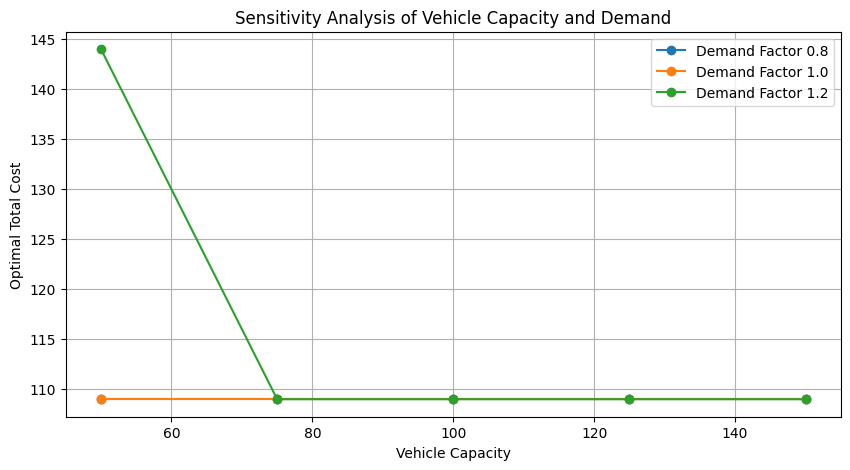

In [103]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt
import random

def run_sensitivity_analysis():
    # Define sets
    nodes = [0, 1, 2, 3, 4]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4]
    vehicles = [0, 1]  # Two vehicles

    # Base Case Data
    base_capacity = 100  # Vehicle capacity
    base_pickup = {1: 10, 2: 15, 3: 20, 4: 25 , 5: 30, 6:35}
    base_delivery = {1: 5, 2: 10, 3: 15, 4: 20 , 5: 25, 6:30}
    distance = {(i, j): random.randint(5, 50) for i in nodes for j in nodes if i != j}
    
    # Make it symmetric
    for i, j in list(distance.keys()):
        distance[j, i] = distance[i, j]

    # Create DataFrame for better display
    distance_matrix = pd.DataFrame(index=nodes, columns=nodes)

    # Fill the matrix
    for i in nodes:
        for j in nodes:
            if i == j:
                distance_matrix.loc[i, j] = "X"  # No self-loops
            else:
                distance_matrix.loc[i, j] = distance[i, j]

    print("\nDistance Matrix:\n")
    print(distance_matrix)


    # Test Scenarios
    capacities = [50, 75, 100, 125, 150]  # Sensitivity on capacity
    demand_factors = [0.8, 1.0, 1.2]  # Sensitivity on pickup & delivery (80%, 100%, 120%)
    
    results = []

    for capacity in capacities:
        for factor in demand_factors:
            # Adjust demand
            pickup = {k: int(base_pickup[k] * factor) for k in base_pickup}
            delivery = {k: int(base_delivery[k] * factor) for k in base_delivery}

            # Initialize the model
            model = gp.Model("VRPSPD_Sensitivity")

            # Decision Variables
            x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
            D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")
            L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")

            # Constraints
            for i in nodes:
                model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

            for j in customer_nodes:
                model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
                model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

            model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= len(vehicles), name="limit_vehicles")

            for i in customer_nodes:
                for j in customer_nodes:
                    model.addConstr(D[i] >= D[j] + delivery[i] - 1000 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
                    model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - 1000 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

            for i in customer_nodes:
                model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_{i}")
                model.addConstr(D[i] <= capacity, name=f"capacity_limit_D_{i}")
                model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_{i}")
                model.addConstr(L[i] <= capacity, name=f"capacity_limit_L_{i}")

            # Objective: Minimize total distance
            model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

            # Solve Model
            model.optimize()

            # Store Results
            if model.status == GRB.OPTIMAL:
                results.append({
                    "Capacity": capacity,
                    "Demand Factor": factor,
                    "Optimal Cost": model.objVal
                })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    print(df_results)


    # Plot Results
    plt.figure(figsize=(10, 5))
    for factor in demand_factors:
        subset = df_results[df_results["Demand Factor"] == factor]
        plt.plot(subset["Capacity"], subset["Optimal Cost"], marker='o', label=f"Demand Factor {factor}")

    plt.xlabel("Vehicle Capacity")
    plt.ylabel("Optimal Total Cost")
    plt.title("Sensitivity Analysis of Vehicle Capacity and Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the sensitivity analysis
run_sensitivity_analysis()



Distance Matrix:

    0   1   2   3   4   5   6
0   X  23  15  19   9  37  27
1  23   X  49  18  46  12  44
2  15  49   X  31  38  38  41
3  19  18  31   X  40  20  21
4   9  46  38  40   X  29  24
5  37  12  38  20  29   X  37
6  27  44  41  21  24  37   X
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 10.0 (19045.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1255U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Academic license 2632106 - for non-commercial use only - registered to a.___@student.tudelft.nl
Optimize a model with 116 rows, 63 columns and 301 nonzeros
Model fingerprint: 0xac08e7b6
Variable types: 14 continuous, 49 integer (49 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [9e+00, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 43 rows and 15 columns
Presolve time: 0.00s
Presolved: 73 rows, 48 columns, 492 n

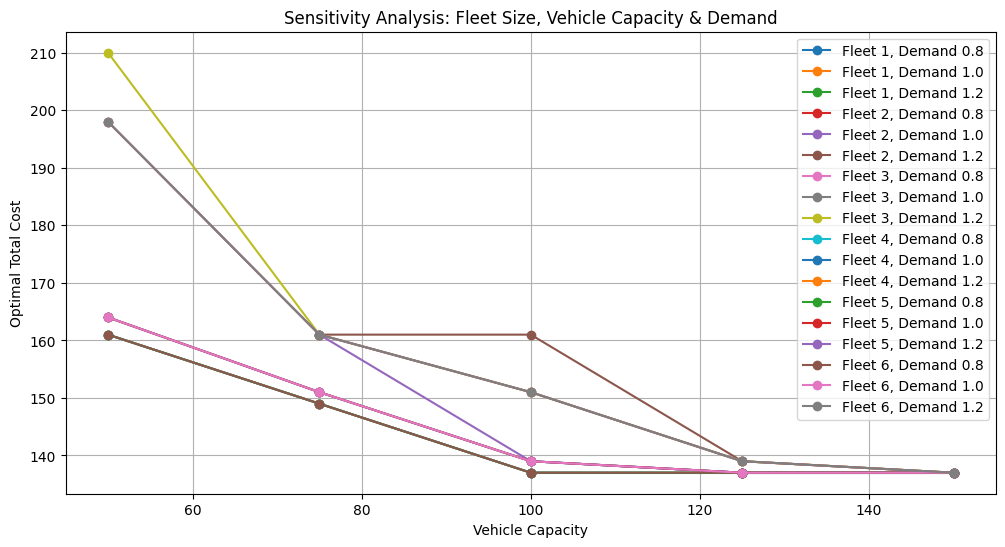

In [104]:
import gurobipy as gp
from gurobipy import GRB, quicksum
import pandas as pd
import matplotlib.pyplot as plt
import random

def extended_sensitivity_analysis():
    # Define sets
    nodes = [0, 1, 2, 3, 4 ,5 ,6]  # 0 is the depot
    customer_nodes = [1, 2, 3, 4 ,5 ,6]

    # Base Case Data
    base_capacity = 100  # Vehicle capacity
    base_pickup = {1: 10, 2: 15, 3: 20, 4: 25, 5: 30, 6: 35}
    base_delivery = {1: 5, 2: 10, 3: 15, 4: 20, 5: 25, 6: 30}
    #distance = {(i, j): 10 for i in nodes for j in nodes if i != j}
    distance = {(i, j): random.randint(5, 50) for i in nodes for j in nodes if i != j}

    # Make it symmetric
    for i, j in list(distance.keys()):
        distance[j, i] = distance[i, j]

    # Create DataFrame for better display
    distance_matrix = pd.DataFrame(index=nodes, columns=nodes)

    # Fill the matrix
    for i in nodes:
        for j in nodes:
            if i == j:
                distance_matrix.loc[i, j] = "X"  # No self-loops
            else:
                distance_matrix.loc[i, j] = distance[i, j]

    print("\nDistance Matrix:\n")
    print(distance_matrix)
    
    # Test Scenarios
    capacities = [50, 75, 100, 125, 150]  # Sensitivity on capacity
    demand_factors = [0.8, 1.0, 1.2]  # Sensitivity on demand
    fleet_sizes = [1, 2, 3, 4, 5,6]  # Number of vehicles available

    results = []

    for K in fleet_sizes:
        for capacity in capacities:
            for factor in demand_factors:
                # Adjust demand
                pickup = {k: int(base_pickup[k] * factor) for k in base_pickup}
                delivery = {k: int(base_delivery[k] * factor) for k in base_delivery}

                if capacity < max(delivery.values()) or capacity < max(pickup.values()):
                    continue

                # Initialize the model
                model = gp.Model("VRPSPD_Fleet_Sensitivity")

                # Decision Variables
                x = model.addVars(nodes, nodes, vtype=GRB.BINARY, name="x")
                D = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="D")
                L = model.addVars(nodes, vtype=GRB.CONTINUOUS, name="L")

                # Constraints
                for i in nodes:
                    model.addConstr(x[i, i] == 0, name=f"no_self_loop_{i}")

                for j in customer_nodes:
                    model.addConstr(quicksum(x[i, j] for i in nodes if i != j) == 1, name=f"leave_once_{j}")
                    model.addConstr(quicksum(x[j, i] for i in nodes if i != j) == 1, name=f"approach_once_{j}")

                model.addConstr(quicksum(x[0, i] for i in customer_nodes) <= K, name="limit_vehicles")

                for i in customer_nodes:
                    for j in customer_nodes:
                        model.addConstr(D[i] >= D[j] + delivery[i] - 1000 * (1 - x[i, j]), name=f"delivery_consistency_{i}_{j}")
                        model.addConstr(L[j] >= L[i] - delivery[j] + pickup[j] - 1000 * (1 - x[i, j]), name=f"load_transfer_{i}_{j}")

                for i in customer_nodes:
                    model.addConstr(delivery[i] <= D[i], name=f"delivery_feasibility_{i}")
                    model.addConstr(D[i] <= capacity, name=f"capacity_limit_D_{i}")
                    model.addConstr(pickup[i] <= L[i], name=f"pickup_feasibility_{i}")
                    model.addConstr(L[i] <= capacity, name=f"capacity_limit_L_{i}")

                # Objective: Minimize total distance
                model.setObjective(quicksum(distance[i, j] * x[i, j] for i in nodes for j in nodes if i != j), GRB.MINIMIZE)

                # Solve Model
                model.optimize()

                # Store Results
                if model.status == GRB.OPTIMAL:
                    results.append({
                        "Fleet Size": K,
                        "Capacity": capacity,
                        "Demand Factor": factor,
                        "Optimal Cost": model.objVal
                    })

    # Convert results to DataFrame
    df_results = pd.DataFrame(results)

    df_results.to_csv("sensitivity_analysis_results.csv", index=False)
    print("Results saved to sensitivity_analysis_results.csv")

    # Print table
    print(df_results)

    # Plot Results
    plt.figure(figsize=(12, 6))
    for K in fleet_sizes:
        subset = df_results[df_results["Fleet Size"] == K]
        for factor in demand_factors:
            data = subset[subset["Demand Factor"] == factor]
            plt.plot(data["Capacity"], data["Optimal Cost"], marker='o', linestyle='-', label=f"Fleet {K}, Demand {factor}")

    plt.xlabel("Vehicle Capacity")
    plt.ylabel("Optimal Total Cost")
    plt.title("Sensitivity Analysis: Fleet Size, Vehicle Capacity & Demand")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run the extended sensitivity analysis
extended_sensitivity_analysis()